In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import logging
import os

In [2]:
logging.basicConfig(filename='logs/training.log', level=logging.INFO, format='%(asctime)s - %(message)s')

In [3]:
start_date = dt.datetime(2020, 4, 1)
end_date = dt.datetime(2023, 4, 1)

In [4]:
stock_symbol = "GOOGL"
try:
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    if data.empty:
        raise ValueError("Downloaded data is empty. Please check the stock symbol or date range.")
except Exception as e:
    logging.error(f"Error downloading data: {e}")
    raise


[*********************100%***********************]  1 of 1 completed


In [5]:
if 'Open' not in data.columns:
    raise ValueError("'Open' column not found in the data.")

In [6]:
if not os.path.exists('data/'):
    os.makedirs('data/')
data.to_csv('data/stock_data.csv')

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open']])

In [8]:
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len:]

In [9]:
def create_sequences(data, time_step=50):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 50
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
def build_rnn_model():
    model = Sequential([
        SimpleRNN(50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        SimpleRNN(50, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_lstm_model():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_gru_model():
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        GRU(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [13]:
def train_and_save_model(model, model_name):
    if not os.path.exists('models/'):
        os.makedirs('models/')
    checkpoint = ModelCheckpoint(f'models/{model_name}.keras', save_best_only=True)
    early_stopping = EarlyStopping(patience=10)
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[checkpoint, early_stopping],
        verbose=2
    )
    logging.info(f'Model {model_name} trained and saved.')
    return model

In [14]:
rnn_model = train_and_save_model(build_rnn_model(), 'rnn_model')
lstm_model = train_and_save_model(build_lstm_model(), 'lstm_model')
gru_model = train_and_save_model(build_gru_model(), 'gru_model')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14/14 - 4s - 289ms/step - loss: 0.2826 - val_loss: 0.0131
Epoch 2/50
14/14 - 1s - 49ms/step - loss: 0.0510 - val_loss: 0.0111
Epoch 3/50
14/14 - 1s - 91ms/step - loss: 0.0186 - val_loss: 0.0026
Epoch 4/50
14/14 - 1s - 63ms/step - loss: 0.0129 - val_loss: 0.0033
Epoch 5/50
14/14 - 1s - 54ms/step - loss: 0.0097 - val_loss: 0.0041
Epoch 6/50
14/14 - 0s - 25ms/step - loss: 0.0079 - val_loss: 0.0027
Epoch 7/50
14/14 - 0s - 28ms/step - loss: 0.0064 - val_loss: 0.0022
Epoch 8/50
14/14 - 1s - 41ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 9/50
14/14 - 1s - 46ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 10/50
14/14 - 0s - 27ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 11/50
14/14 - 0s - 29ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 12/50
14/14 - 0s - 27ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 13/50
14/14 - 1s - 44ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 14/50
14/14 - 0s - 27ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 15/50
14/14 - 1s - 44ms/step - loss:

In [15]:
y_pred_rnn = rnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


In [16]:
y_pred_rnn = scaler.inverse_transform(y_pred_rnn).flatten()
y_pred_lstm = scaler.inverse_transform(y_pred_lstm).flatten()
y_pred_gru = scaler.inverse_transform(y_pred_gru).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [17]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    logging.info(f'{model_name} - MSE: {mse}, MAE: {mae}, R2: {r2}')
    print(f'{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

evaluate_model(y_test, y_pred_rnn, 'RNN')
evaluate_model(y_test, y_pred_lstm, 'LSTM')
evaluate_model(y_test, y_pred_gru, 'GRU')

RNN - MSE: 11.2638, MAE: 2.6533, R2: 0.5656
LSTM - MSE: 30.2001, MAE: 4.5146, R2: -0.1646
GRU - MSE: 11.5466, MAE: 2.8083, R2: 0.5547


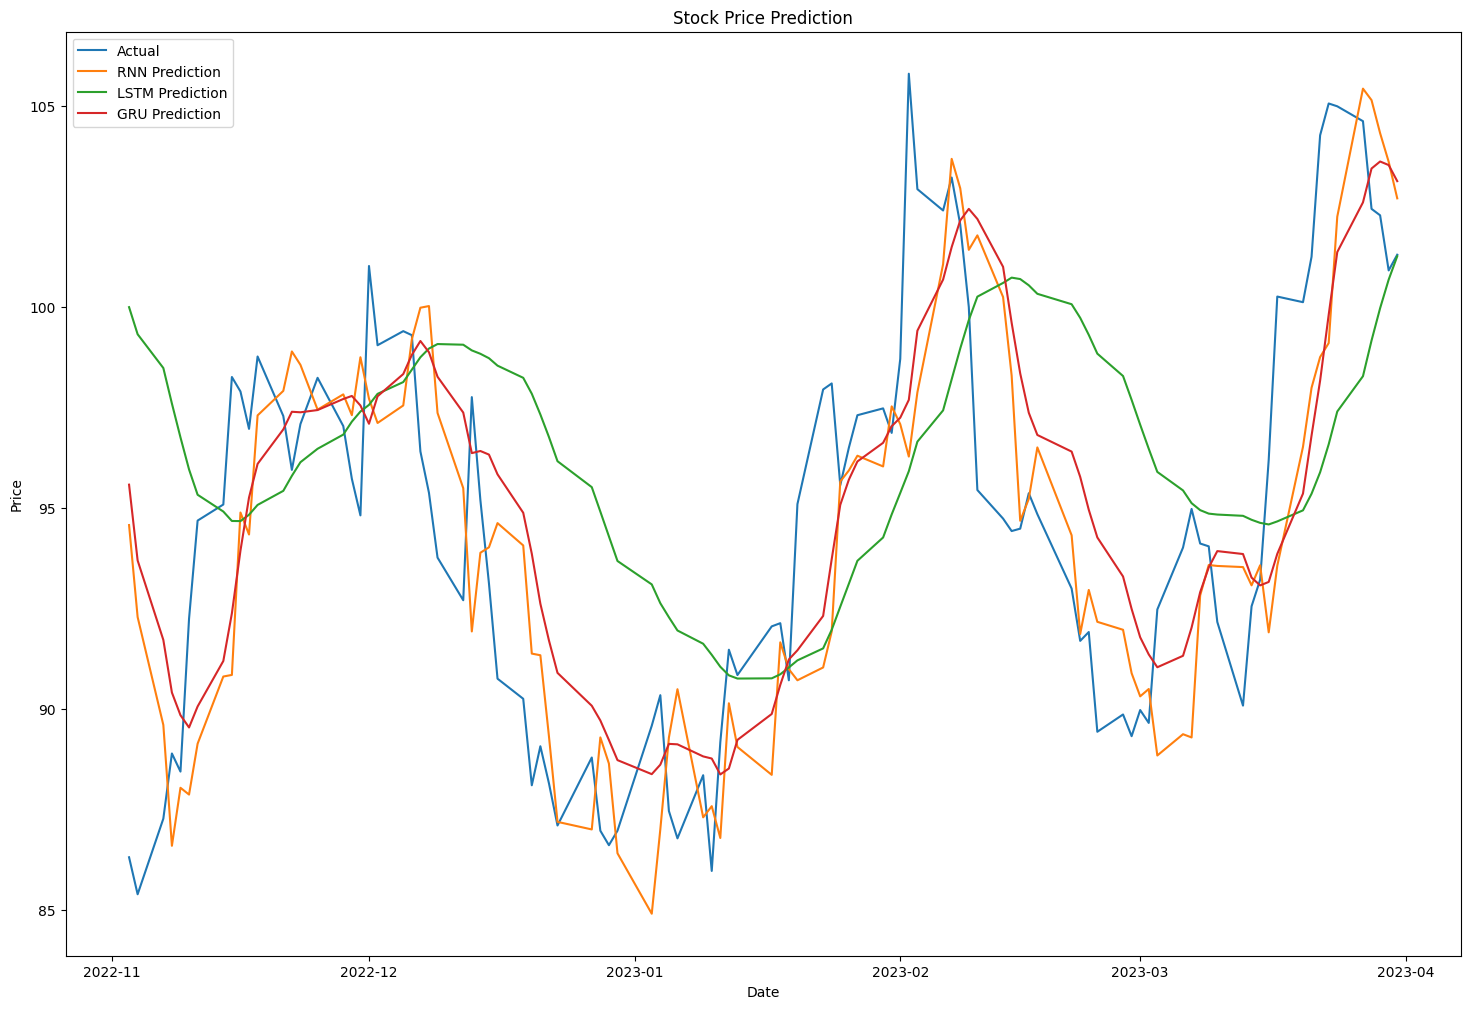

In [18]:
plt.figure(figsize=(18, 12))
plt.plot(data.index[-len(y_test):], y_test, label='Actual')
plt.plot(data.index[-len(y_pred_rnn):], y_pred_rnn, label='RNN Prediction')
plt.plot(data.index[-len(y_pred_lstm):], y_pred_lstm, label='LSTM Prediction')
plt.plot(data.index[-len(y_pred_gru):], y_pred_gru, label='GRU Prediction')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()